In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdramdani","key":"0850d17ece69fcc4d3fdbf3d1fa789d4"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 
!kaggle datasets download -d ruchi798/bookcrossing-dataset

 75% 57.0M/76.1M [00:01<00:00, 44.3MB/s]
100% 76.1M/76.1M [00:01<00:00, 67.9MB/s]


In [ ]:
#code to extract bookcrossing-dataset.zip
from zipfile import ZipFile
file_name="bookcrossing-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")


done


In [ ]:
#import
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt



In [ ]:
books_data=pd.read_csv("/content/Books Data with Category Language and Summary/Preprocessed_data.csv",low_memory=False)
books_rat=pd.read_csv("/content/Book reviews/Book reviews/BX-Book-Ratings.csv",sep=';', encoding='latin-1',low_memory=False)
users=pd.read_csv("/content/Book reviews/Book reviews/BX-Users.csv",sep=';', encoding='latin-1',low_memory=False)

1) le traitement sur le dataset books_data
-jenleve les columns non utilisé 
-les isbn qui se repete 
-les livres avec le problem de description =9 


In [ ]:
books_data=books_data.rename(columns={"isbn":"ISBN"})
print(books_data.shape,"\n",list(books_data.columns))


(1031175, 19) 
 ['Unnamed: 0', 'user_id', 'location', 'age', 'ISBN', 'rating', 'book_title', 'book_author', 'year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l', 'Summary', 'Language', 'Category', 'city', 'state', 'country']


In [ ]:
drop_c=['user_id','Unnamed: 0','age', 'location' , 'city', 'state', 'country',"rating"]
books_data=books_data.drop(drop_c,axis=1)

In [ ]:
books_data=books_data.drop_duplicates(subset="ISBN") 
books_data=books_data.drop_duplicates(subset="Summary")
#on enleve les column avec l'erreur de 9 
books_data=books_data[books_data["Summary"]!="9"]
books_data=books_data[books_data["Category"]!="9"]
#je garde que les livres en anglais 
books_data=books_data[books_data["Language"]=="en"]
print(books_data.shape)

(129982, 11)


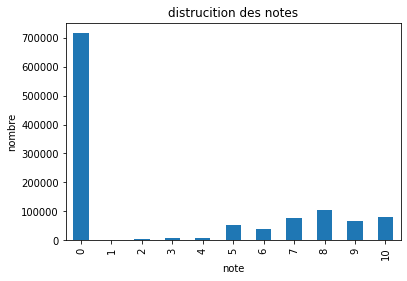

In [ ]:
#distrubution des ratting with 0 
plt.rc("font")
books_rat["Book-Rating"].value_counts(sort=False).plot(kind="bar")
plt.title("distrucition des notes")
plt.xlabel("note")
plt.ylabel("nombre")
plt.show()

jajoute 2 columns de average rating et la somme des notes \\
jutilise le dataset des notes \\
jenleve les notes 0 \\
jenleve les livres qui ne se trouve pas dans mon dataset d'user

In [ ]:

#add two column average & somme rating 
#keeping only explicit rattings #0
print("dataset des rating avant : ",books_rat.shape,books_rat["ISBN"].nunique(),books_rat["User-ID"].nunique())
books_rat_nnul=books_rat[books_rat["Book-Rating"]!=0]
print("dataset des rating apres l'elimination des valeurs ==0 : ",books_rat_nnul.shape,books_rat_nnul["ISBN"].nunique(),books_rat_nnul["User-ID"].nunique())


#average_rating
average_book=pd.DataFrame(books_rat_nnul.groupby("ISBN")["Book-Rating"].mean()).reset_index().rename(columns={"Book-Rating":"average_rating"})
#average_book.sort_values(by="average_rating",ascending=False)

books_data=pd.merge(books_data,average_book, on ="ISBN")

#somme rating
book_rating_Count=(books_rat_nnul.groupby(by=["ISBN"])["Book-Rating"].count().reset_index().
                   rename(columns={"Book-Rating":"SommeRating"}))
books_data=pd.merge(books_data,book_rating_Count, on ="ISBN")
print(books_data.shape)
#books_data

dataset des rating avant :  (1149780, 3) 340556 105283
dataset des rating apres l'elimination des valeurs ==0 :  (433671, 3) 185973 77805
(75288, 13)


In [ ]:
#remove implicit rating =0
books_rating=pd.merge(books_rat_nnul,books_data["ISBN"],on="ISBN")
print(books_rating.shape,books_rating.columns)

(216926, 3) Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')


In [ ]:

#user with >15 ratting
print(books_rating.shape,books_rating["User-ID"].nunique(),books_rating["ISBN"].nunique())
#groupe1= books_rat_nnul["User-ID"].value_counts()
groupe1=pd.DataFrame(books_rating.groupby("User-ID")["ISBN"].count()).reset_index().rename(columns={"ISBN":"Nb_book_rated"})
print(groupe1.shape)
groupe1=groupe1.query("Nb_book_rated >=15")
print(groupe1.shape)
books_rat2=pd.merge(books_rating,groupe1["User-ID"], on ="User-ID",how="inner")
print(books_rat2.shape,books_rat2["User-ID"].nunique(),books_rat2["ISBN"].nunique())

(216926, 3) 46162 75288
(46162, 2)
(2563, 2)
(118152, 3) 2563 55031


In [ ]:
#only books that exist in books_rat2
books_rat_isbn=books_rat2.drop_duplicates(subset="ISBN")
print(books_rat_isbn.shape)
books_data2=pd.merge(books_data,books_rat_isbn["ISBN"], on ="ISBN",how="inner")
print(books_data2.shape,books_rat2["ISBN"].nunique())

(55031, 3)
(55031, 13) 55031


In [ ]:
#only users that exist in new books_rating
users=users.merge((books_rat2.drop_duplicates(subset="User-ID"))["User-ID"],on="User-ID",how="inner")
users.shape

(2563, 3)

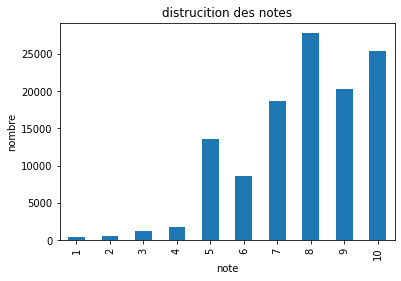

In [ ]:

#distrubution des notes sans les 0 apres  
plt.rc("font")
books_rat2["Book-Rating"].value_counts(sort=False).plot(kind="bar")
plt.title("distrucition des notes")
plt.xlabel("note")
plt.ylabel("nombre")
plt.show()


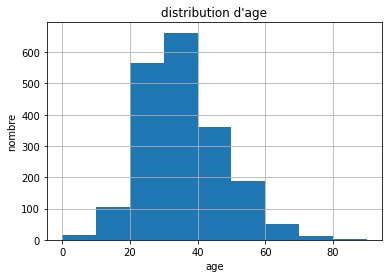

In [ ]:
#

users["Age"].hist(bins=[0,10,20,30,40,50,60,70,80,90])
plt.title("distribution d'age")
plt.xlabel("age")
plt.ylabel("nombre")
plt.show()


au fianl \\ les resultat changer ..
apres elimination des livres avec des summary =="9" \\
des livres dans le dataset des rating qui ont été evalué qu'avec 0  \\
on a 527255 rating, 78951 livres ,  62975 utilisateur \\
si jelimine les utilisateur ou il ont noté des livres par 0 je trouve \\
234253 rating, 82478 livres , 49979 utilisateur \\
pour le dataset des livres \\
livres avec average rating >6 : 62127 \\
livres avec average rating <= 6 : 16824 \\
livres avec somme rating >=10 : 3570  \\ 
livres avec somme rating <10 : 75381  \\
 pour les rating \\
 cas       | utilisateur >=15| utilisateur <15 \\
 ____________
 sans les 0|    5016 |57959                      \\
 ____________
 avec les 0|   2693 | 44843                                 \\
 __________
 

In [ ]:
#pour le traiment de Summary
!pip install nltk 

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer #

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet') #

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#tokenizatoin 
def tok(text):
  return word_tokenize(str(text))


In [ ]:
#on enleve les ponctuation 
def enleve_ponct(text):
  #symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
  symbols = "!\"0123456789#$%'&()*+-./:;<=>?@[\]^_`{|}~\n"
  for i in range(len(symbols)):
      text = np.char.replace(text, symbols[i], ' ')
      text = np.char.replace(text, "  ", " ")
  text = np.char.replace(text, ',', '')
  return str(text)
  

In [ ]:
#z="Harry Potter is a series of seven fantasy novels written by British author J. K. Rowling. The novels chronicle the lives of a young wizard, Harry Potter, and his friends Hermione Granger and Ron Weasley, all of whom are students at Hogwarts School of Witchcraft and Wizardry."
print("input : ",z)
z=tok(z)
print("output : ",z)

input :   harry potter series seven fantasy novels written british author rowling novels chronicle lives young wizard harry potter friends hermione granger ron weasley students hogwarts school witchcraft wizardry
output :  ['harry', 'potter', 'series', 'seven', 'fantasy', 'novels', 'written', 'british', 'author', 'rowling', 'novels', 'chronicle', 'lives', 'young', 'wizard', 'harry', 'potter', 'friends', 'hermione', 'granger', 'ron', 'weasley', 'students', 'hogwarts', 'school', 'witchcraft', 'wizardry']


In [ ]:
a=tok(z)
print(a)

['harri', 'potter', 'seri', 'seven', 'fantasi', 'novel', 'written', 'british', 'author', 'rowl', 'novel', 'chronicl', 'live', 'young', 'wizard', 'harri', 'potter', 'friend', 'hermion', 'granger', 'ron', 'weasley', 'student', 'hogwart', 'school', 'witchcraft', 'wizardri']


In [ ]:
input : Harry Potter is a series of seven fantasy novels written by British author J. K. Rowling !. The novels 
        chronicle the lives of a young wizard, Harry Potter, and his friends Hermione Granger and Ron Weasley
        , all of whom are students at Hogwarts School of Witchcraft and Wizardry."

input: harry potter is a series of seven fantasy novels written by british author j k rowling the novels 
        chronicle the lives of a young wizard harry potter and his friends hermione granger and ron weasley 
        all of whom are students at hogwarts school of witchcraft and wizardry

input:['harry', 'potter', 'is', 'a', 'series', 'of', 'seven', 'fantasy', 'novels', 'written', 'by', 'british'
      , 'author', 'j', 'k', 'rowling', 'the', 'novels', 'chronicle', 'the', 'lives', 'of', 'a', 'young', 'wizard'
      , 'harry', 'potter', 'and', 'his', 'friends', 'hermione', 'granger', 'and', 'ron', 'weasley', 'all', 'of', 'whom'
      , 'are', 'students', 'at', 'hogwarts', 'school', 'of', 'witchcraft', 'and', 'wizardry']

input:['harry', 'potter', 'series', 'seven', 'fantasy', 'novels', 'written', 'british', 'author', 'rowling'
      , 'novels', 'chronicle', 'lives', 'young', 'wizard', 'harry', 'potter', 'friends', 'hermione', 'granger'
      , 'ron', 'weasley', 'students', 'hogwarts', 'school', 'witchcraft', 'wizardry']

output:['harry', 'potter', 'series', 'seven', 'fantasy', 'novels', 'written', 'british', 'author', 'rowling'
      , 'novels', 'chronicle', 'lives', 'young', 'wizard', 'harry', 'potter', 'friends', 'hermione', 'granger'
      , 'ron', 'weasley', 'students', 'hogwarts', 'school', 'witchcraft', 'wizardry']


In [ ]:
# le text en miniscule 
def miniscule(text):
  return str(np.char.lower(text))
  #return text.lower() 

In [ ]:
#stop words
def remove_stop_words(text):
  stop_words = stopwords.words('english')
  words = word_tokenize(str(text))
  new_text = ""
  for w in words:
    if w not in stop_words and len(w) > 2:# and (not w.isdigit()):
      new_text = new_text + " " + w
  return new_text

In [ ]:
#Stemming connection connected ... -> connect 
def stemm(text):
  ps=PorterStemmer()
  new_text=""
  words=word_tokenize(str(text))
  for word in words:
    new_text=new_text+" "+ps.stem(word)
  return new_text


In [ ]:
#Lemmatization
def lemm(text):
  lem = WordNetLemmatizer()
  new_text=""
  words=word_tokenize(str(text))
  for word in words:
    new_text=new_text+" "+lem.lemmatize(word,"v")
  return new_text

In [ ]:
def traitement(row):
  text=row["Summary"]
  text=enleve_ponct(text)
  text=miniscule(text)
  #text=stemm(text)
  text=remove_stop_words(text)
  #text=tok(text)
  #text=lemm(text)
  return text

In [ ]:
"""
# i save the 3 new dataset
books_data["Text"]=books_data.apply(traitement,axis=1)
books_data.to_csv('books_data_text_notoken.csv') 
files.download('books_data_text_notoken.csv')
"""

'\n# i save the 3 new dataset\nbooks_data["Text"]=books_data.apply(traitement,axis=1)\nbooks_data.to_csv(\'books_data_text_notoken.csv\') \nfiles.download(\'books_data_text_notoken.csv\')\n'

In [ ]:
#books category

category=pd.DataFrame(books_data2.groupby("Category")["ISBN"].count()).reset_index().rename(columns={"ISBN":"nb"})
(category.sort_values(by="nb",ascending=False)).head(37)

,Category,nb
1711,['Fiction'],24200
2120,['Juvenile Fiction'],4060
673,['Biography & Autobiography'],2100
1939,['History'],1239
2638,['Religion'],1117
2121,['Juvenile Nonfiction'],1012
2010,['Humor'],870
1242,['Cooking'],801
2755,['Social Science'],797
730,"['Body, Mind & Spirit']",782


In [ ]:
print(books_data2.shape,books_rat2["ISBN"].nunique(),books_rat2["User-ID"].nunique(),users.shape)

(55031, 13) 55031 2563 (2563, 3)


In [ ]:
#save book dataset
books_data2.to_csv("books_data_final.csv")
files.download("books_data_final.csv")

pickle_out=open("books_data_final.pickle","wb")
pickle.dump(books_data2,pickle_out)
pickle_out.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

#save rating dataset
books_rat2.to_csv("books_rating_final.csv")
files.download("books_rating_final.csv")

pickle_out=open("books_rating_final.pickle","wb")
pickle.dump(books_rat2,pickle_out)
pickle_out.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#save user dataset
users.to_csv("users_final.csv")
files.download("users_final.csv")

pickle_out=open("users_final.pickle","wb")
pickle.dump(users,pickle_out)
pickle_out.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
list(books_rat2.columns)

['User-ID', 'ISBN', 'Book-Rating']